In [1]:
import pandas as pd
import tabensemb
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

tabensemb.setting["matplotlib_usetex"] = True
tabensemb._stream_filters = ["DeprecationWarning"]

from tabensemb.trainer import load_trainer
import matplotlib


# Random

In [2]:
trainer = load_trainer("output/composite_database_10082023/2023-12-14-23-09-20-0_composite Random 622 extracted/trainer.pkl")

## Physics/DL weight

In [ ]:
import os
import numpy as np
thiswork = trainer.get_modelbase(program="ThisWork")
train_weights = pd.DataFrame(columns=[x for x in thiswork.get_model_names() if "PHYSICS" not in x], index=trainer.train_indices)
val_weights = pd.DataFrame(columns=[x for x in thiswork.get_model_names() if "PHYSICS" not in x], index=trainer.val_indices)
test_weights = pd.DataFrame(columns=[x for x in thiswork.get_model_names() if "PHYSICS" not in x], index=trainer.test_indices)
for idx, model_name in enumerate(thiswork.get_model_names()):
    if "PHYSICS" not in model_name:
        res = thiswork.inspect_weighted_predictions(model_name=model_name)
        train_weights[model_name] = res["train"]["dl_weight"]
        val_weights[model_name] = res["val"]["dl_weight"]
        test_weights[model_name] = res["test"]["dl_weight"]

In [4]:
x_cluster = thiswork.inspect_attr(
            model_name="PHYSICS_NoPCA_KMeans", attributes=["x_cluster"]
        )

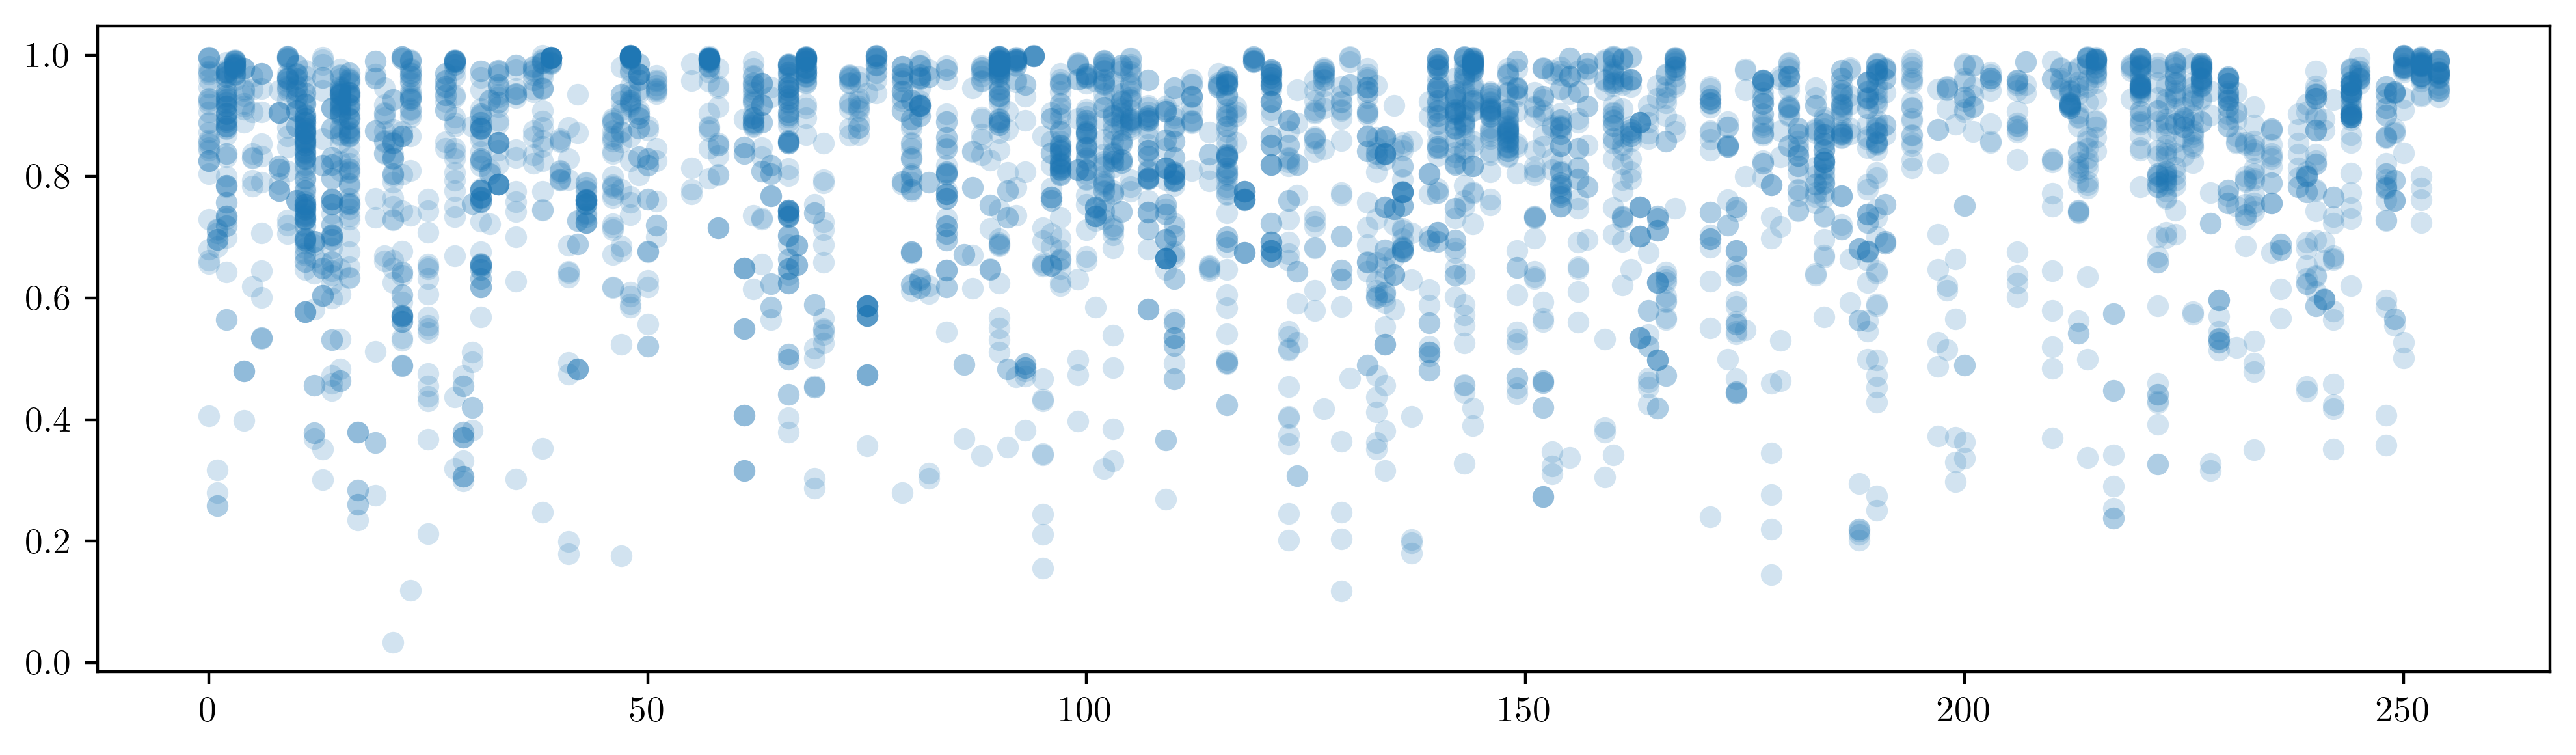

In [5]:
plt.figure(figsize=(10, 3), dpi=400)
plt.scatter(x_cluster["train"]["x_cluster"], train_weights.values[:, 3], linewidths=0, alpha=0.2)
plt.show()
plt.close()

PearsonRResult(statistic=0.388228966945035, pvalue=2.8660434196234213e-08)


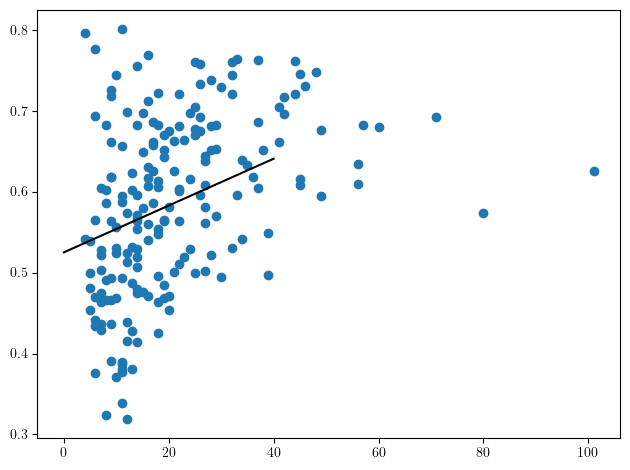

In [6]:
from scipy.stats import pearsonr

plt.figure()
cnt_weights = []
for i in range(np.max(x_cluster["train"]["x_cluster"])):
    is_this_cluster = np.where(x_cluster["train"]["x_cluster"]==i)[0]
    cnt_weights.append((len(is_this_cluster), train_weights.mean(axis=1).values[is_this_cluster]))
# plt.scatter(x_cluster["train"]["x_cluster"], train_weights.values[:, 3], linewidths=0, alpha=0.2)
x = [x[0] for x in cnt_weights if x[0]!=0]
y = [np.mean(x[1]) for x in cnt_weights if x[0]!=0]
plt.scatter(x, y)
r = pearsonr(x, y)
print(r)
pfit = np.polyfit(x, y, 1)
k, b = pfit[0], pfit[1]
plt.plot(np.linspace(0, 40, 3), k*np.linspace(0, 40, 3)+b, color="k", label="Linear fitting")
plt.show()
plt.close()

PearsonRResult(statistic=-0.17157366434595742, pvalue=0.017632048283707104)


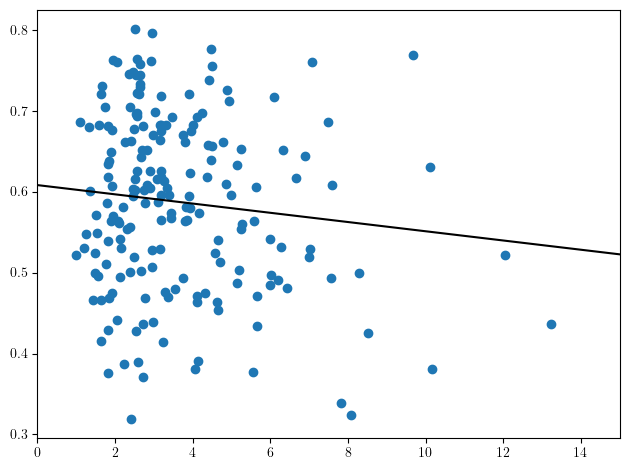

In [17]:
plt.figure()
model = thiswork.model["PHYSICS_NoPCA_KMeans"]
cnt_weights = []
for i in range(np.max(x_cluster["train"]["x_cluster"])):
    is_this_cluster = np.where(x_cluster["train"]["x_cluster"]==i)[0]
    cnt_weights.append((len(is_this_cluster), np.sqrt(np.sum(np.power(model.clustering.centers[i, :].cpu().numpy(), 2))), train_weights.mean(axis=1).values[is_this_cluster]))
# plt.scatter(x_cluster["train"]["x_cluster"], train_weights.values[:, 3], linewidths=0, alpha=0.2)
x = [x[1] for x in cnt_weights if x[0]!=0]
y = [np.mean(x[2]) for x in cnt_weights if x[0]!=0]
plt.scatter(x, y)
r = pearsonr(x, y)
print(r)
pfit = np.polyfit(x, y, 1)
k, b = pfit[0], pfit[1]
plt.plot(np.linspace(0, 40, 3), k*np.linspace(0, 40, 3)+b, color="k", label="Linear fitting")
plt.xlim([0, 15])
plt.show()
plt.close()

In [12]:
model = thiswork.model["PHYSICS_NoPCA_KMeans"]
model.clustering.centers[0, :], trainer.feature_data.loc[trainer.train_indices, trainer.cont_feature_names].mean(axis=0)

(tensor([-0.7240,  0.1920,  1.1362, -1.0242, -0.3852, -0.2321,  0.3281,  0.4209,
         -0.1473,  0.1619,  0.1002,  0.2410, -0.3070,  0.2840, -0.4585, -0.3712,
         -0.2096,  0.0331,  0.0069, -0.3791]),
 Fiber Volume Fraction                -0.007155
 Fiber Weight Fraction                 0.002252
 Fiber Weight Fraction (0-deg)        -0.001227
 Fiber Weight Fraction (45-deg)       -0.006438
 Fiber Weight Fraction (90-deg)        0.012214
 Fiber Weight Fraction (Other Dir.)   -0.001601
 Thickness                            -0.000646
 Tab Thickness                        -0.001991
 Width                                -0.008372
 Length                               -0.008094
 Load Length                          -0.011643
 Area                                 -0.002837
 Maximum Stress                        0.004776
 Minimum Stress                       -0.002323
 Maximum Strain                       -0.007445
 Minimum Strain                        0.000517
 R-value               

In [135]:
[np.mean(x[1]) for x in cnt_weights]

/home/xlluo/anaconda3/envs/tabular_ensemble/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xlluo/anaconda3/envs/tabular_ensemble/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


[0.7600679,
 0.33864734,
 0.6823986,
 0.6649972,
 0.75434595,
 0.6599211,
 0.55957687,
 nan,
 0.60486823,
 0.7595019,
 0.72327566,
 0.624129,
 0.41363916,
 0.5881932,
 0.49466673,
 0.7164782,
 0.6337665,
 0.32096854,
 nan,
 0.5327748,
 0.5742909,
 0.5221618,
 0.59719336,
 0.73250234,
 nan,
 0.4595886,
 nan,
 0.47660264,
 0.6526877,
 0.3798743,
 0.4682887,
 0.6107663,
 0.43821272,
 0.52149326,
 nan,
 0.56230944,
 nan,
 0.69758815,
 0.68087566,
 0.71461457,
 0.6186112,
 0.5851508,
 0.5212577,
 0.501085,
 nan,
 nan,
 0.60291475,
 0.5072793,
 0.76205945,
 0.50249875,
 0.5415828,
 0.51701015,
 nan,
 nan,
 nan,
 0.50097704,
 nan,
 0.7637609,
 0.48512855,
 nan,
 nan,
 0.4271722,
 0.6722188,
 0.577152,
 0.53057235,
 nan,
 0.5740508,
 0.43163463,
 0.6859519,
 0.31910416,
 0.4384658,
 nan,
 nan,
 0.5113528,
 0.65801483,
 0.4703513,
 0.69555056,
 nan,
 nan,
 0.5771408,
 0.59501153,
 0.6077426,
 0.3885833,
 nan,
 0.66305655,
 nan,
 0.47347125,
 0.47624373,
 0.56808805,
 0.5250873,
 0.69535756,
 0.

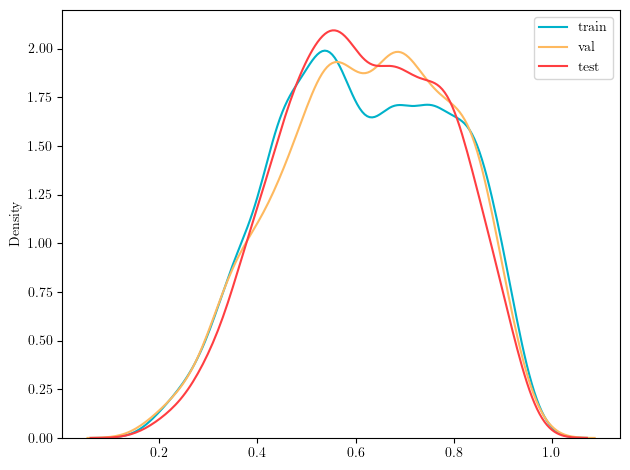

In [113]:
plt.figure()
ax = plt.subplot(111)
sns.kdeplot(train_weights.mean(axis=1), label="train", ax=ax, color=tabensemb.utils.global_palette[0])
sns.kdeplot(val_weights.mean(axis=1), label="val", ax=ax, color=tabensemb.utils.global_palette[1])
sns.kdeplot(test_weights.mean(axis=1), label="test", ax=ax, color=tabensemb.utils.global_palette[2])
plt.legend()
plt.show()
plt.close()

In [61]:
train_weights.describe()

,AutoGluon_LightGBM_NoWrap_NoPCA_KMeans,AutoGluon_CatBoost_NoWrap_NoPCA_KMeans,AutoGluon_XGBoost_NoWrap_NoPCA_KMeans,AutoGluon_Random Forest_NoWrap_NoPCA_KMeans,AutoGluon_Extremely Randomized Trees_NoWrap_NoPCA_KMeans,AutoGluon_K-Nearest Neighbors_NoWrap_NoPCA_KMeans,AutoGluon_Linear Regression_NoWrap_NoPCA_KMeans,AutoGluon_Neural Network with PyTorch_NoWrap_NoPCA_KMeans,AutoGluon_Neural Network with FastAI_NoWrap_NoPCA_KMeans,WideDeep_TabMlp_Wrap_NoPCA_KMeans,...,WideDeep_SelfAttentionMLP_Wrap_NoPCA_KMeans,WideDeep_FTTransformer_Wrap_NoPCA_KMeans,WideDeep_TabPerceiver_Wrap_NoPCA_KMeans,WideDeep_TabFastFormer_Wrap_NoPCA_KMeans,PytorchTabular_Category Embedding_Wrap_NoPCA_KMeans,PytorchTabular_NODE_NoWrap_NoPCA_KMeans,PytorchTabular_TabNet_NoWrap_NoPCA_KMeans,PytorchTabular_TabTransformer_Wrap_NoPCA_KMeans,PytorchTabular_AutoInt_Wrap_NoPCA_KMeans,PytorchTabular_FTTransformer_Wrap_NoPCA_KMeans
count,4062.000000,4062.000000,4062.000000,4062.000000,4.062000e+03,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,...,4062.000000,4.062000e+03,4062.000000,4062.000000,4062.000000,4062.000000,4062.000000,4.062000e+03,4.062000e+03,4062.000000
mean,0.810166,0.806119,0.832192,0.814634,8.222337e-01,0.512068,0.399228,0.734561,0.615932,0.560625,...,0.604141,6.198633e-01,0.700480,0.627329,0.680680,0.488215,0.543292,3.260927e-01,5.690632e-01,0.674753
std,0.214532,0.239975,0.225959,0.168414,2.668692e-01,0.317056,0.352218,0.107035,0.121386,0.389073,...,0.369647,3.897692e-01,0.299629,0.300027,0.378920,0.134913,0.162907,4.002424e-01,4.250600e-01,0.338281
min,0.015529,0.000023,0.000367,0.033375,4.975390e-11,0.000004,0.000011,0.003909,0.004290,0.000037,...,0.000051,4.881230e-12,0.001002,0.004355,0.000018,0.000081,0.000380,1.107500e-13,8.315512e-10,0.000135
25%,0.681286,0.677845,0.735875,0.734861,7.201812e-01,0.213682,0.055095,0.672092,0.539419,0.149773,...,0.252344,2.909223e-01,0.493665,0.373144,0.364352,0.405799,0.445474,1.899349e-03,2.414799e-02,0.390903
50%,0.900601,0.922019,0.946745,0.865642,9.769725e-01,0.529748,0.308504,0.740741,0.613450,0.627852,...,0.682531,6.576864e-01,0.819603,0.696377,0.918733,0.490016,0.541697,5.500927e-02,6.310978e-01,0.813772
75%,0.982735,0.988916,0.993241,0.945100,9.987738e-01,0.801942,0.727729,0.808674,0.694873,0.972749,...,0.978488,9.996078e-01,0.957074,0.908012,0.997763,0.568392,0.653574,7.370677e-01,9.993140e-01,0.980825
max,0.999999,1.000000,1.000000,0.999432,1.000000e+00,0.999950,0.999822,0.957997,0.999964,0.999998,...,1.000000,1.000000e+00,0.999999,0.999300,1.000000,0.956793,0.988263,9.999998e-01,1.000000e+00,1.000000


Not normal distributed along the model axis

<Axes: ylabel='Count'>

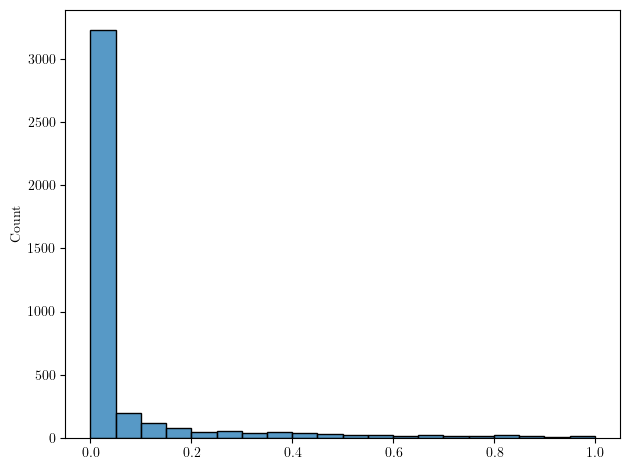

In [64]:
pvals = [st.shapiro(train_weights.loc[idx, :]).pvalue for idx in train_weights.index]
sns.histplot(pvals, bins=20)


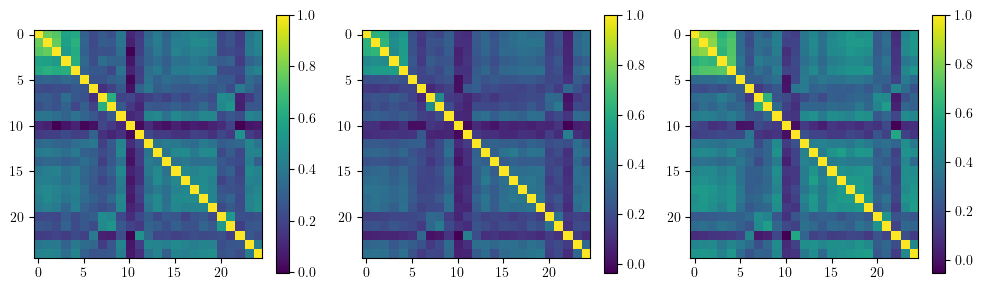

In [65]:
plt.figure(figsize=(10, 3))
ax = plt.subplot(131)
im = ax.imshow(train_weights.corr())
plt.colorbar(mappable=im)
ax = plt.subplot(132)
im = ax.imshow(train_weights.corr(method="kendall"))
plt.colorbar(mappable=im)
ax = plt.subplot(133)
im = ax.imshow(train_weights.corr(method="spearman"))
plt.colorbar(mappable=im)
plt.show()
plt.close()

Clear correlation though modest between each two models, thus we choose to analyse the average of dl train_weights of different models.

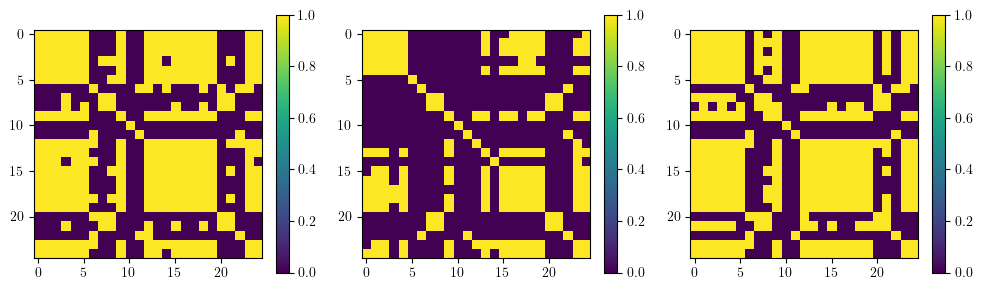

In [66]:
plt.figure(figsize=(10, 3))
ax = plt.subplot(131)
im = ax.imshow(train_weights.corr()>0.3)
plt.colorbar(mappable=im)
ax = plt.subplot(132)
im = ax.imshow(train_weights.corr(method="kendall")>0.3)
plt.colorbar(mappable=im)
ax = plt.subplot(133)
im = ax.imshow(train_weights.corr(method="spearman")>0.3)
plt.colorbar(mappable=im)
plt.show()
plt.close()

In [67]:
avg_weights = train_weights.mean(axis=1)
avg_weights

3395    0.530107
3663    0.625181
2746    0.649821
4293    0.500532
1948    0.877779
          ...   
1856    0.249194
5927    0.633046
3324    0.670028
6344    0.785524
4271    0.340934
Length: 4062, dtype: float32

No clear preference of ML/physics considering high-cycle or low-cycle data

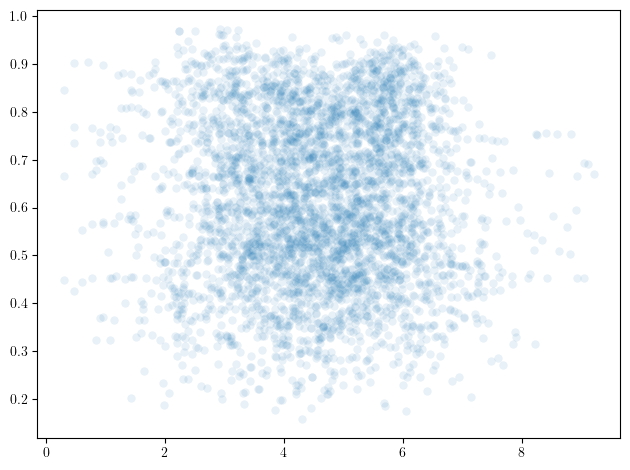

In [69]:
plt.figure()
plt.scatter(trainer.df.loc[trainer.train_indices, trainer.label_name], avg_weights, alpha=0.1, linewidths=0)
plt.show()
plt.close()

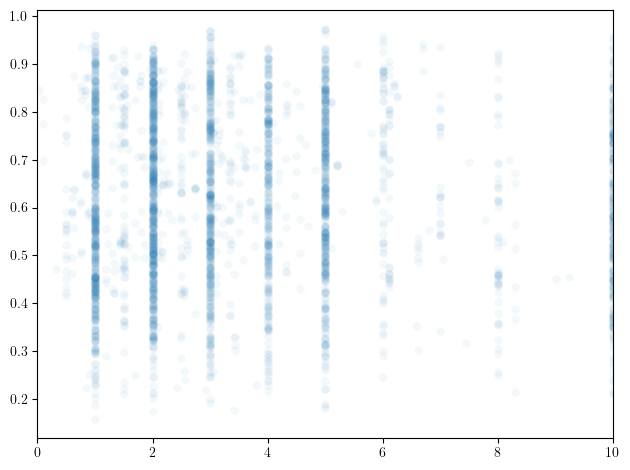

In [70]:
plt.figure()
plt.scatter(trainer.df.loc[trainer.train_indices, ["Frequency"]], avg_weights, alpha=0.05, linewidths=0)
plt.xlim([0, 10])
plt.show()
plt.close()

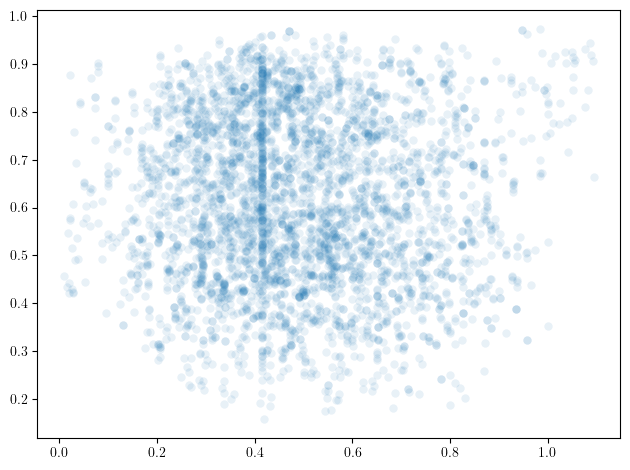

In [90]:
plt.figure()
plt.scatter(trainer.df.loc[trainer.train_indices, ["Relative Maximum Stress"]], avg_weights, alpha=0.1, linewidths=0)
# plt.xlim([0, 10])
plt.show()
plt.close()

In [ ]:
plt.figure()
plt.scatter(trainer.df.loc[trainer.train_indices, ["Relative Maximum Stress"]], avg_weights, alpha=0.1, linewidths=0)
# plt.xlim([0, 10])
plt.show()
plt.close()

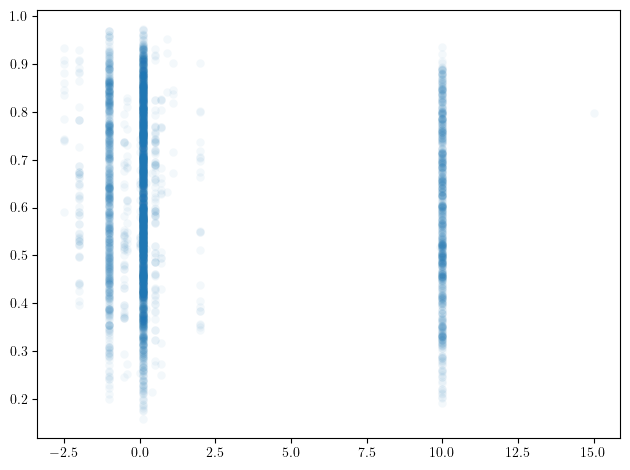

In [71]:
plt.figure()
plt.scatter(trainer.df.loc[trainer.train_indices, ["R-value"]], avg_weights, alpha=0.05, linewidths=0)
# plt.xlim([0, 10])
plt.show()
plt.close()

/tmp/ipykernel_10020/2307040306.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=avg_weights.loc[indices], ax=ax, label=str(round(r_val, 1)), color="blue", alpha=(idx+1)/len(unique_values))
/tmp/ipykernel_10020/2307040306.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=avg_weights.loc[indices], ax=ax, label=str(round(r_val, 1)), color="blue", alpha=(idx+1)/len(unique_values))


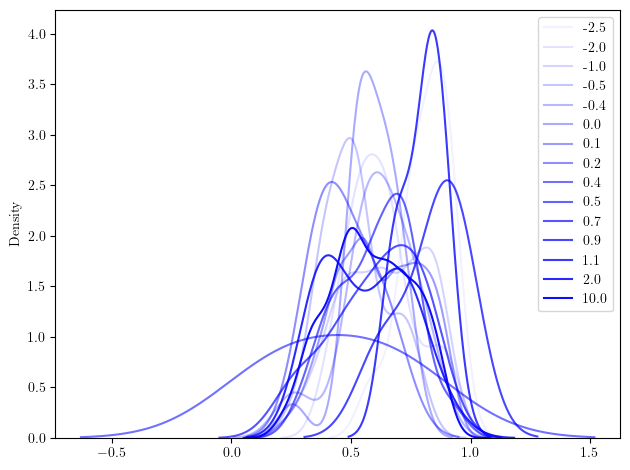

In [76]:
plt.figure()
ax = plt.subplot(111)
unique_values = np.unique(trainer.df["R-value"])
for idx, r_val in enumerate(unique_values):
    indices = trainer.datamodule.select_by_value(selection={"R-value": r_val}, partition="train")
    sns.kdeplot(data=avg_weights.loc[indices], ax=ax, label=str(round(r_val, 1)), color="blue", alpha=(idx+1)/len(unique_values))
plt.legend()
plt.show()
plt.close()

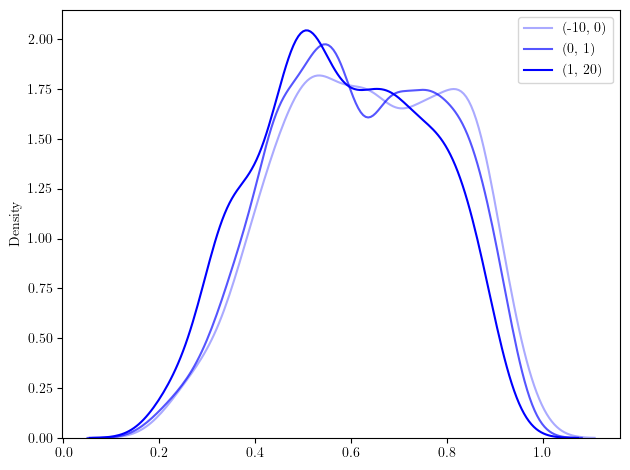

In [77]:
plt.figure()
ax = plt.subplot(111)
ranges = [(-10, 0), (0, 1), (1, 20)]
for idx, r_val in enumerate(ranges):
    indices = trainer.datamodule.select_by_value(selection={"R-value": r_val}, partition="train")
    sns.kdeplot(data=avg_weights.loc[indices], ax=ax, label=str(r_val), color="blue", alpha=(idx+1)/len(ranges))
plt.legend()
plt.show()
plt.close()

In [45]:
trainer.cont_feature_names

['Fiber Volume Fraction',
 'Fiber Weight Fraction',
 'Fiber Weight Fraction (0-deg)',
 'Fiber Weight Fraction (45-deg)',
 'Fiber Weight Fraction (90-deg)',
 'Fiber Weight Fraction (Other Dir.)',
 'Thickness',
 'Tab Thickness',
 'Width',
 'Length',
 'Load Length',
 'Area',
 'Maximum Stress',
 'Minimum Stress',
 'Maximum Strain',
 'Minimum Strain',
 'R-value',
 'Frequency',
 'Ultimate Tensile Stress',
 'Ultimate Compressive Stress',
 'Tensile Modulus',
 'Compressive Modulus',
 'Ultimate Tensile Strain',
 'Ultimate Compressive Strain',
 'Relative Maximum Stress',
 'Relative Stress Range',
 'Relative Mean Stress']

In [81]:
cnt_weights = []
mat_code_set = list(sorted(set(trainer.df["Material_Code"])))
for c in mat_code_set:
    indices = trainer.select_by_material_code(m_code=c, partition="train")
    cnt_weights.append((len(indices), avg_weights.loc[indices]))

In [82]:
cnt_weights

[(7,
  4964    0.696568
  4958    0.699490
  4967    0.670740
  4963    0.449152
  4962    0.694058
  4959    0.473414
  4968    0.671241
  dtype: float32),
 (8,
  4954    0.839245
  4952    0.793551
  4945    0.699723
  4943    0.674224
  4948    0.851813
  4955    0.803393
  4951    0.817502
  4950    0.847834
  dtype: float32),
 (1,
  5181    0.815574
  dtype: float32),
 (3,
  5179    0.672409
  5178    0.821380
  5123    0.515177
  dtype: float32),
 (10,
  5379    0.750755
  5297    0.705259
  5148    0.491990
  5326    0.711457
  5299    0.684927
  5309    0.421989
  5308    0.441176
  5380    0.611481
  5377    0.543287
  5296    0.617912
  dtype: float32),
 (24,
  5461    0.921781
  5435    0.868628
  5331    0.467042
  5444    0.588545
  5436    0.317646
  5438    0.832326
  5434    0.223444
  5433    0.807650
  5520    0.522074
  5295    0.809453
  5446    0.451086
  5150    0.804009
  5460    0.852069
  5452    0.888903
  5521    0.531760
  5448    0.620404
  5293    0.775066

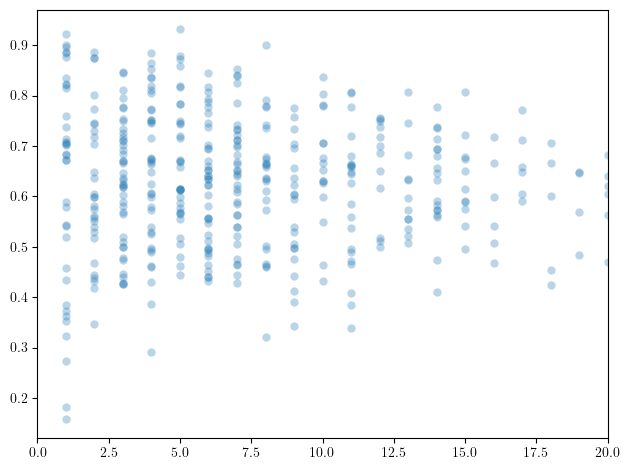

In [87]:
plt.figure()
plt.scatter([x[0] for x in cnt_weights], [np.mean(x[1]) for x in cnt_weights], linewidths=0, alpha=0.3)
plt.xlim([0, 20])
plt.show()
plt.close()

# Cycle

In [91]:
trainer = load_trainer("output/composite_database_10082023/2023-12-17-21-22-17-0_composite StressCycle 622 extracted/trainer.pkl")

In [ ]:
import os
import numpy as np
thiswork = trainer.get_modelbase(program="ThisWork")
train_weights = pd.DataFrame(columns=[x for x in thiswork.get_model_names() if "PHYSICS" not in x], index=trainer.train_indices)
val_weights = pd.DataFrame(columns=[x for x in thiswork.get_model_names() if "PHYSICS" not in x], index=trainer.val_indices)
test_weights = pd.DataFrame(columns=[x for x in thiswork.get_model_names() if "PHYSICS" not in x], index=trainer.test_indices)
for idx, model_name in enumerate(thiswork.get_model_names()):
    if "PHYSICS" not in model_name:
        res = thiswork.inspect_weighted_predictions(model_name=model_name)
        train_weights[model_name] = res["train"]["dl_weight"]
        val_weights[model_name] = res["val"]["dl_weight"]
        test_weights[model_name] = res["test"]["dl_weight"]

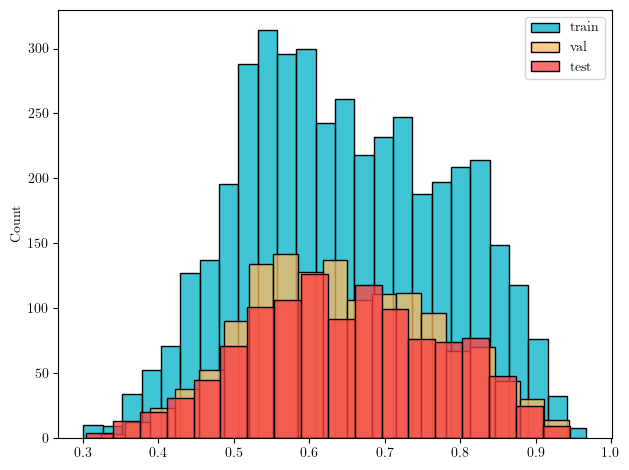

In [96]:
plt.figure()
ax = plt.subplot(111)
sns.histplot(train_weights.mean(axis=1), label="train", ax=ax, color=tabensemb.utils.global_palette[0])
sns.histplot(val_weights.mean(axis=1), label="val", ax=ax, color=tabensemb.utils.global_palette[1])
sns.histplot(test_weights.mean(axis=1), label="test", ax=ax, color=tabensemb.utils.global_palette[2])
plt.legend()
plt.show()
plt.close()

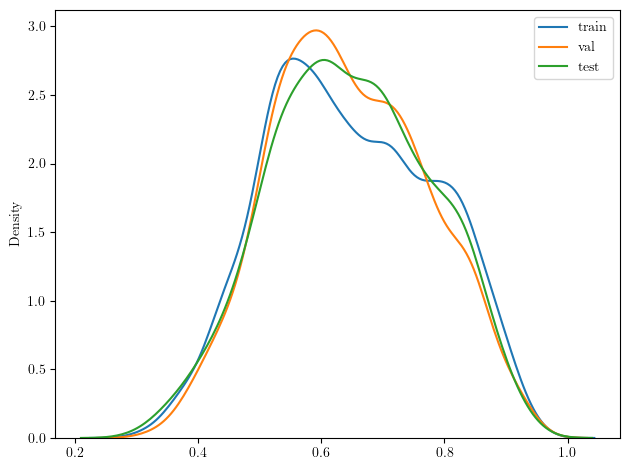

In [97]:
plt.figure()
ax = plt.subplot(111)
sns.kdeplot(train_weights.mean(axis=1), label="train", ax=ax)
sns.kdeplot(val_weights.mean(axis=1), label="val", ax=ax)
sns.kdeplot(test_weights.mean(axis=1), label="test", ax=ax)
plt.legend()
plt.show()
plt.close()

In [98]:
trainer = load_trainer("output/composite_database_10082023/2023-12-12-18-37-31-0_composite StressCycle 316 extracted/trainer.pkl")

In [ ]:
import os
import numpy as np
thiswork = trainer.get_modelbase(program="ThisWork")
train_weights = pd.DataFrame(columns=[x for x in thiswork.get_model_names() if "PHYSICS" not in x], index=trainer.train_indices)
val_weights = pd.DataFrame(columns=[x for x in thiswork.get_model_names() if "PHYSICS" not in x], index=trainer.val_indices)
test_weights = pd.DataFrame(columns=[x for x in thiswork.get_model_names() if "PHYSICS" not in x], index=trainer.test_indices)
for idx, model_name in enumerate(thiswork.get_model_names()):
    if "PHYSICS" not in model_name:
        res = thiswork.inspect_weighted_predictions(model_name=model_name)
        train_weights[model_name] = res["train"]["dl_weight"]
        val_weights[model_name] = res["val"]["dl_weight"]
        test_weights[model_name] = res["test"]["dl_weight"]

In [107]:
st.normaltest(train_weights.mean(axis=1)), st.normaltest(val_weights.mean(axis=1)), st.normaltest(test_weights.mean(axis=1)),

(NormaltestResult(statistic=509.845022771373, pvalue=1.9433901279988194e-111),
 NormaltestResult(statistic=69.89322986861485, pvalue=6.650862553816389e-16),
 NormaltestResult(statistic=199.1292897737213, pvalue=5.749421292015508e-44))

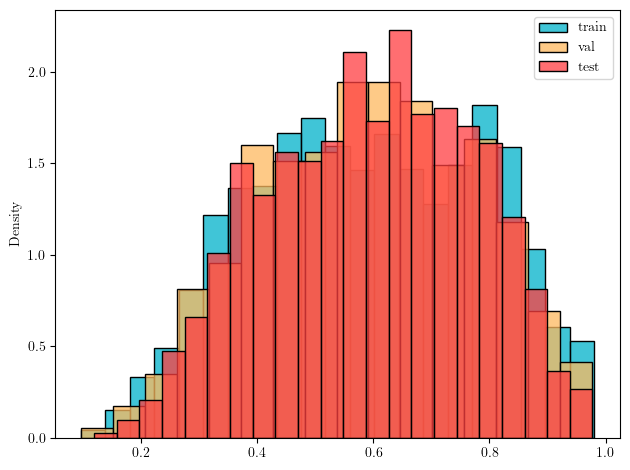

In [102]:
plt.figure()
ax = plt.subplot(111)
sns.histplot(train_weights.mean(axis=1), label="train", ax=ax, color=tabensemb.utils.global_palette[0], stat="density")
sns.histplot(val_weights.mean(axis=1), label="val", ax=ax, color=tabensemb.utils.global_palette[1], stat="density")
sns.histplot(test_weights.mean(axis=1), label="test", ax=ax, color=tabensemb.utils.global_palette[2], stat="density")
plt.legend()
plt.show()
plt.close()

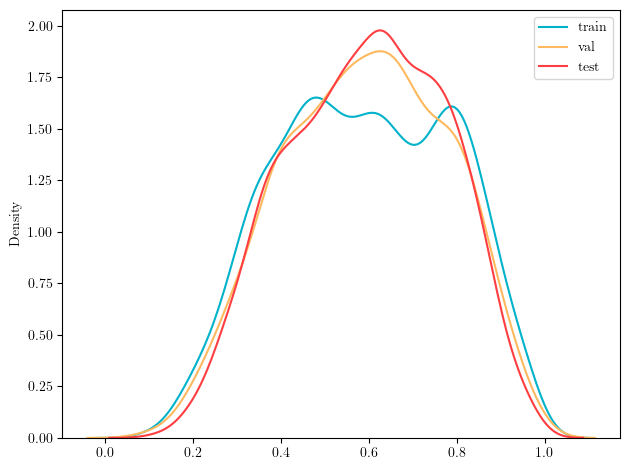

In [104]:
plt.figure()
ax = plt.subplot(111)
sns.kdeplot(train_weights.mean(axis=1), label="train", ax=ax, color=tabensemb.utils.global_palette[0])
sns.kdeplot(val_weights.mean(axis=1), label="val", ax=ax, color=tabensemb.utils.global_palette[1])
sns.kdeplot(test_weights.mean(axis=1), label="test", ax=ax, color=tabensemb.utils.global_palette[2])
plt.legend()
plt.show()
plt.close()

In [110]:
st.ttest_ind(train_weights.mean(axis=1), val_weights.mean(axis=1))

TtestResult(statistic=-0.23169796684770608, pvalue=0.8167839547237274, df=4179.0)